In [1]:
import pandas as pd
import numpy as np
import os
from lcfunctions import download_lasair_lc, display_lightcurve
from lcfunctions import lasair_clean, load_lasair_lc
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Generate dataset

In [2]:
label_scheme = 'labels_2'

pd.options.display.max_columns = None

dataset = pd.read_csv(f'../processed_data/dataset_allfeatures_inc_labels.csv', low_memory=False)
dataset = dataset[dataset[label_scheme].notna()].reset_index(drop=True)
print(dataset[label_scheme].value_counts())
print(dataset.shape)
pd.options.display.max_rows= None
# missing = dataset.isnull().sum()/len(dataset)
# missing.sort_values(ascending=False)

from metadatafeatures import distance, absmag

# Add absolute g magnitude column
dataset['absmag_ztf_g'] = absmag(dataset['median_g'], dataset['distance'])
# Add absolute r magnitude column
dataset['absmag_ztf_r'] = absmag(dataset['median_r'], dataset['distance'])

dataset['periodLStest_g'] = 1/dataset['freq_pwr_max_g']
# dataset[['periodLStest_g','PeriodLS_g','labels_2']]


dwarf_nova_SU_UMa    630
dwarf_nova_Z_Cam     174
nova_like            144
nova_like_VY_Scl     120
dwarf_nova_U_Gem     116
polar                114
int_polar             49
AMCVn                 46
nova                  46
Name: labels_2, dtype: int64
(1439, 270)


In [3]:
dataset.columns.tolist()

['oid_ztf',
 'oid_aavso',
 'type_aavso',
 'Eclipsing',
 'CV_Types',
 'CV_subtypes',
 'CV_subsubtypes',
 'eclipse_clear',
 'manual_label',
 'Clarity',
 'labels_1',
 'labels_2',
 'labels_3',
 'labels_4',
 'Amplitude_g',
 'AndersonDarling_g',
 'Autocor_length_g',
 'Beyond1Std_g',
 'CAR_mean_g',
 'CAR_sigma_g',
 'CAR_tau_g',
 'Con_g',
 'Eta_e_g',
 'FluxPercentileRatioMid20_g',
 'FluxPercentileRatioMid35_g',
 'FluxPercentileRatioMid50_g',
 'FluxPercentileRatioMid65_g',
 'FluxPercentileRatioMid80_g',
 'Freq1_harmonics_amplitude_0_g',
 'Freq1_harmonics_amplitude_1_g',
 'Freq1_harmonics_amplitude_2_g',
 'Freq1_harmonics_amplitude_3_g',
 'Freq1_harmonics_rel_phase_1_g',
 'Freq1_harmonics_rel_phase_2_g',
 'Freq1_harmonics_rel_phase_3_g',
 'Freq2_harmonics_amplitude_0_g',
 'Freq2_harmonics_amplitude_1_g',
 'Freq2_harmonics_amplitude_2_g',
 'Freq2_harmonics_amplitude_3_g',
 'Freq2_harmonics_rel_phase_1_g',
 'Freq2_harmonics_rel_phase_2_g',
 'Freq2_harmonics_rel_phase_3_g',
 'Freq3_harmonics_amplit

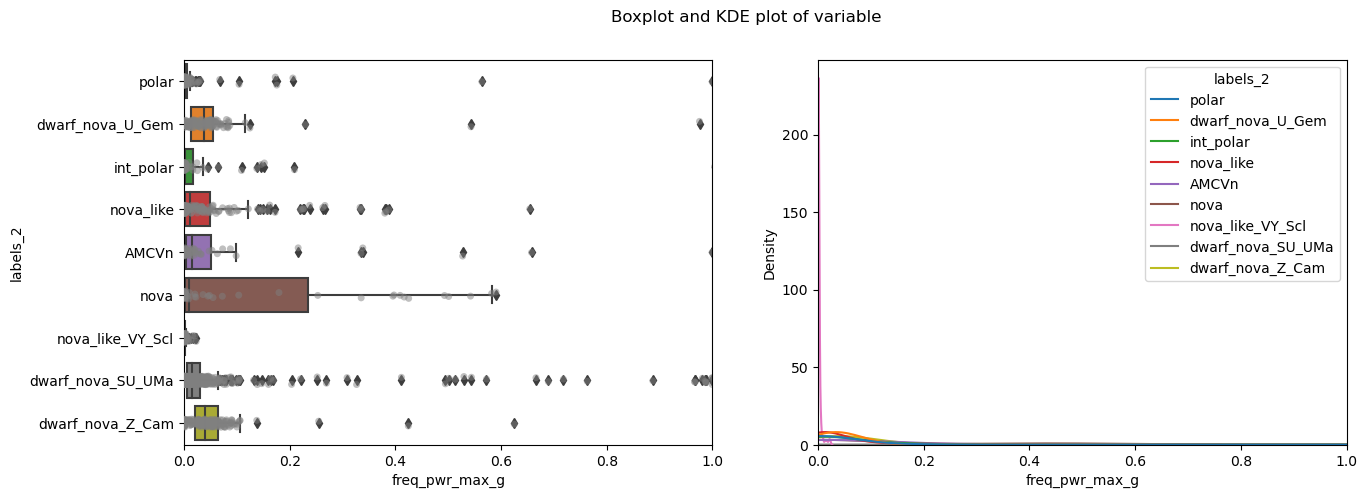

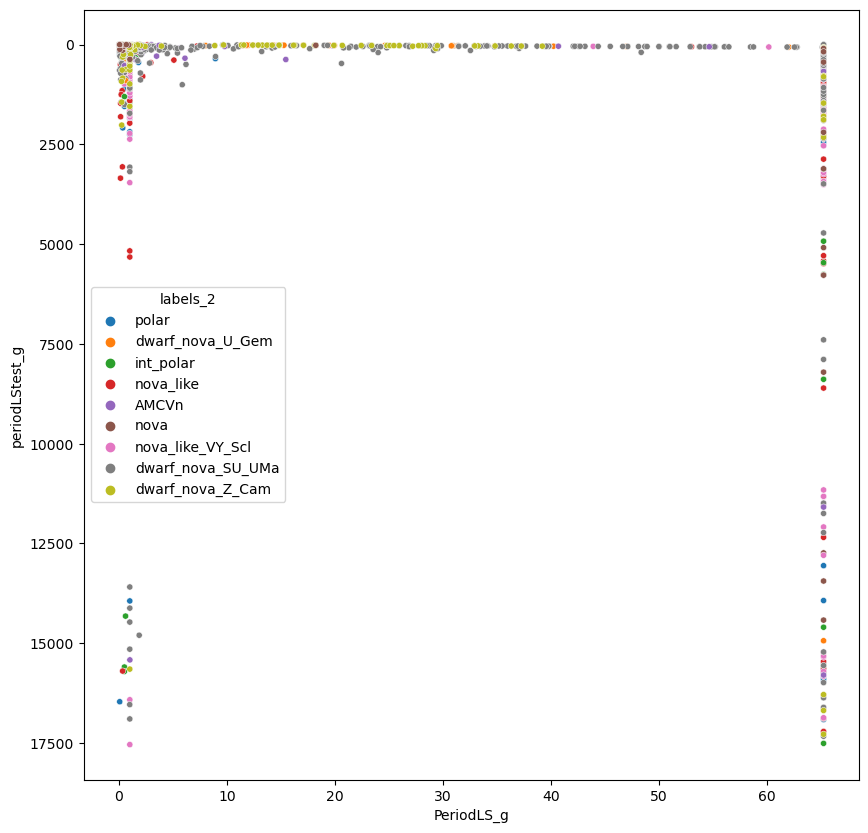

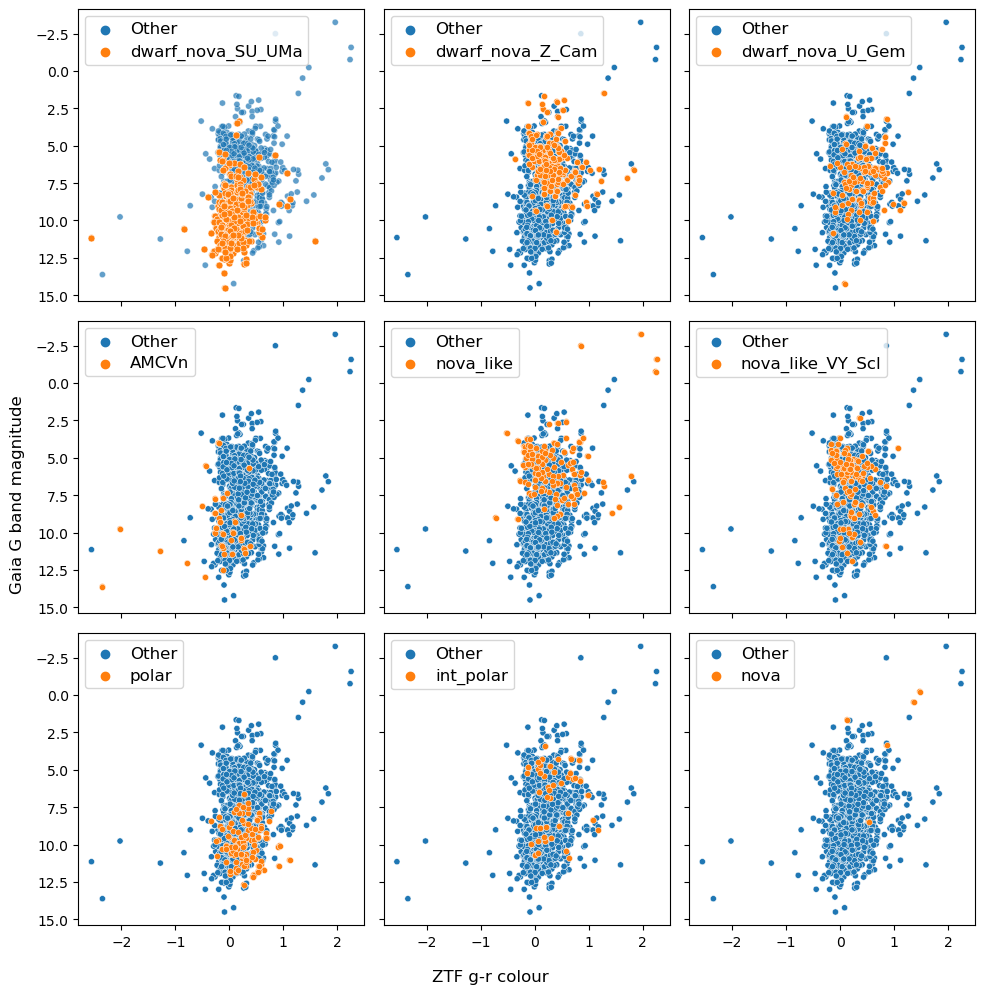

seaborn.axisgrid.FacetGrid

In [4]:
import seaborn as sns
from matplotlib import pyplot as plt
dataframe = dataset
name = 'freq_pwr_max_g'
limits = (0,1)
labels = 'labels_2'
plt.rcdefaults()


fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False)
fig.suptitle('Boxplot and KDE plot of variable')

sns.boxplot(ax=axes[0], data=dataframe, x=name, y=labels)
sns.stripplot(ax=axes[0], data=dataframe, x=name, y=labels, color='grey', alpha=0.5)
axes[0].set(xlim=limits)
sns.kdeplot(ax=axes[1], x=name, data=dataframe, hue=labels, common_norm=False)
axes[1].set(xlim=limits)
plt.show()


# dataframe[name].hist(bins=75, grid=False,figsize=(5,3))
fig2 = plt.figure(figsize=(10,10))
sns.scatterplot(data=dataframe, x='PeriodLS_g', y='periodLStest_g', hue=labels, alpha=1,s=20)
#invert y axis
plt.gca().invert_yaxis()
plt.savefig(f'../figures/cmd_gminusr.pdf', bbox_inches='tight', format='pdf')
plt.show()

# Construct a figure of clr_mean vs absmag_g where the hue is for AM CVns stars and the remaining stars
# are plotted in grey. The figure is saved to a pdf file.
dataframe_ovr = dataset[['clr_mean','bp_rp','absmag_g', 'absmag_ztf_g', 'absmag_ztf_r', 'absmag_bp', 'absmag_rp', label_scheme]]
for cvclass in np.unique(dataframe_ovr[label_scheme]).tolist():
    dataframe_ovr.loc[(dataframe_ovr.labels_2.isin([cvclass])), cvclass] = cvclass
    dataframe_ovr.loc[(dataframe_ovr.labels_2.isin([cvclass]) == False), cvclass] = 'Other'



x = 'clr_mean'
y= 'absmag_g'
f1 = 12
f2 = 12
f3 = 10

fig3, ax = plt.subplots(nrows=3,ncols=3,figsize=(10,10), layout='tight', sharex=True, sharey=True)
fig3.supxlabel('ZTF g-r colour', fontsize=f1)
fig3.supylabel('Gaia G band magnitude', fontsize=f1)
sns.scatterplot(ax=ax[0,0],data=dataframe_ovr, x=x, y=y, hue='dwarf_nova_SU_UMa', alpha=0.7,s=20, legend='brief')
sns.scatterplot(ax=ax[0,0],data=dataframe_ovr[dataframe_ovr['dwarf_nova_SU_UMa']=='dwarf_nova_SU_UMa'], x=x, y=y, alpha=1,s=25)
ax[0,0].invert_yaxis()
ax[0,0].set(ylabel=None)
plt.setp(ax[0,0].get_legend().get_texts(), fontsize=f2) # for legend text
sns.scatterplot(ax=ax[0,1],data=dataframe_ovr, x=x, y=y, hue='dwarf_nova_Z_Cam', alpha=1,s=20,legend='brief')
sns.scatterplot(ax=ax[0,1],data=dataframe_ovr[dataframe_ovr['dwarf_nova_Z_Cam']=='dwarf_nova_Z_Cam'], x=x, y=y, alpha=1,s=20)
ax[0,1].invert_yaxis()
plt.setp(ax[0,1].get_legend().get_texts(), fontsize=f2) # for legend text
sns.scatterplot(ax=ax[0,2],data=dataframe_ovr, x=x, y=y, hue='dwarf_nova_U_Gem', alpha=1,s=20,legend='brief')
sns.scatterplot(ax=ax[0,2],data=dataframe_ovr[dataframe_ovr['dwarf_nova_U_Gem']=='dwarf_nova_U_Gem'], x=x, y=y, alpha=1,s=20)
ax[0,2].invert_yaxis()
plt.setp(ax[0,2].get_legend().get_texts(), fontsize=f2) # for legend text
sns.scatterplot(ax=ax[1,0],data=dataframe_ovr, x=x, y=y, hue='AMCVn', alpha=1,s=20,legend='brief')
sns.scatterplot(ax=ax[1,0],data=dataframe_ovr[dataframe_ovr['AMCVn']=='AMCVn'], x=x, y=y, alpha=1,s=20,legend='brief')
ax[1,0].invert_yaxis()
ax[1,0].set(ylabel=None)
plt.setp(ax[1,0].get_legend().get_texts(), fontsize=f2) # for legend text
sns.scatterplot(ax=ax[1,1],data=dataframe_ovr, x=x, y=y, hue='nova_like', alpha=1,s=20,legend='brief')
sns.scatterplot(ax=ax[1,1],data=dataframe_ovr[dataframe_ovr['nova_like']=='nova_like'], x=x, y=y, alpha=1,s=20,legend='brief')
ax[1,1].invert_yaxis()
plt.setp(ax[1,1].get_legend().get_texts(), fontsize=f2) # for legend text
sns.scatterplot(ax=ax[1,2],data=dataframe_ovr, x=x, y=y, hue='nova_like_VY_Scl', alpha=1,s=20,legend='brief')
sns.scatterplot(ax=ax[1,2],data=dataframe_ovr[dataframe_ovr['nova_like_VY_Scl']=='nova_like_VY_Scl'], x=x, y=y, alpha=1,s=20,legend='brief')
ax[1,2].invert_yaxis()
plt.setp(ax[1,2].get_legend().get_texts(), fontsize=f2) # for legend text
sns.scatterplot(ax=ax[2,0],data=dataframe_ovr, x=x, y=y, hue='polar', hue_order=('Other','polar'),alpha=1,s=20,legend='brief')
sns.scatterplot(ax=ax[2,0],data=dataframe_ovr[dataframe_ovr['polar']=='polar'], x=x, y=y,alpha=1,s=20,legend='brief')
ax[2,0].invert_yaxis()
ax[2,0].set(xlabel=None)
ax[2,0].set(ylabel=None)
plt.setp(ax[2,0].get_legend().get_texts(), fontsize=f2) # for legend text
sns.scatterplot(ax=ax[2,1],data=dataframe_ovr, x=x, y=y, hue='int_polar', alpha=1,s=20,legend='brief')
sns.scatterplot(ax=ax[2,1],data=dataframe_ovr[dataframe_ovr['int_polar']=='int_polar'], x=x, y=y, alpha=1,s=20,legend='brief')
ax[2,1].invert_yaxis()
ax[2,1].set(xlabel=None)
plt.setp(ax[2,1].get_legend().get_texts(), fontsize=f2) # for legend text
sns.scatterplot(ax=ax[2,2],data=dataframe_ovr, x=x, y=y, hue='nova', alpha=1,s=20,legend='brief')
sns.scatterplot(ax=ax[2,2],data=dataframe_ovr[dataframe_ovr['nova']=='nova'], x=x, y=y, alpha=1,s=20,legend='brief')
ax[2,2].invert_yaxis()
ax[2,2].set(xlabel=None)

ax[2,0].xaxis.set_tick_params(labelsize=f3)
ax[2,1].xaxis.set_tick_params(labelsize=f3)
ax[2,2].xaxis.set_tick_params(labelsize=f3)
ax[0,0].yaxis.set_tick_params(labelsize=f3)
ax[1,0].yaxis.set_tick_params(labelsize=f3)
ax[2,0].yaxis.set_tick_params(labelsize=f3)

plt.setp(ax[2,2].get_legend().get_texts(), fontsize=f2) # for legend text
plt.savefig(f'../figures/cmd_Gvsgminusr.pdf', bbox_inches='tight', format='pdf')

plt.show()

sns.FacetGrid


### Example light curves of different CV classes

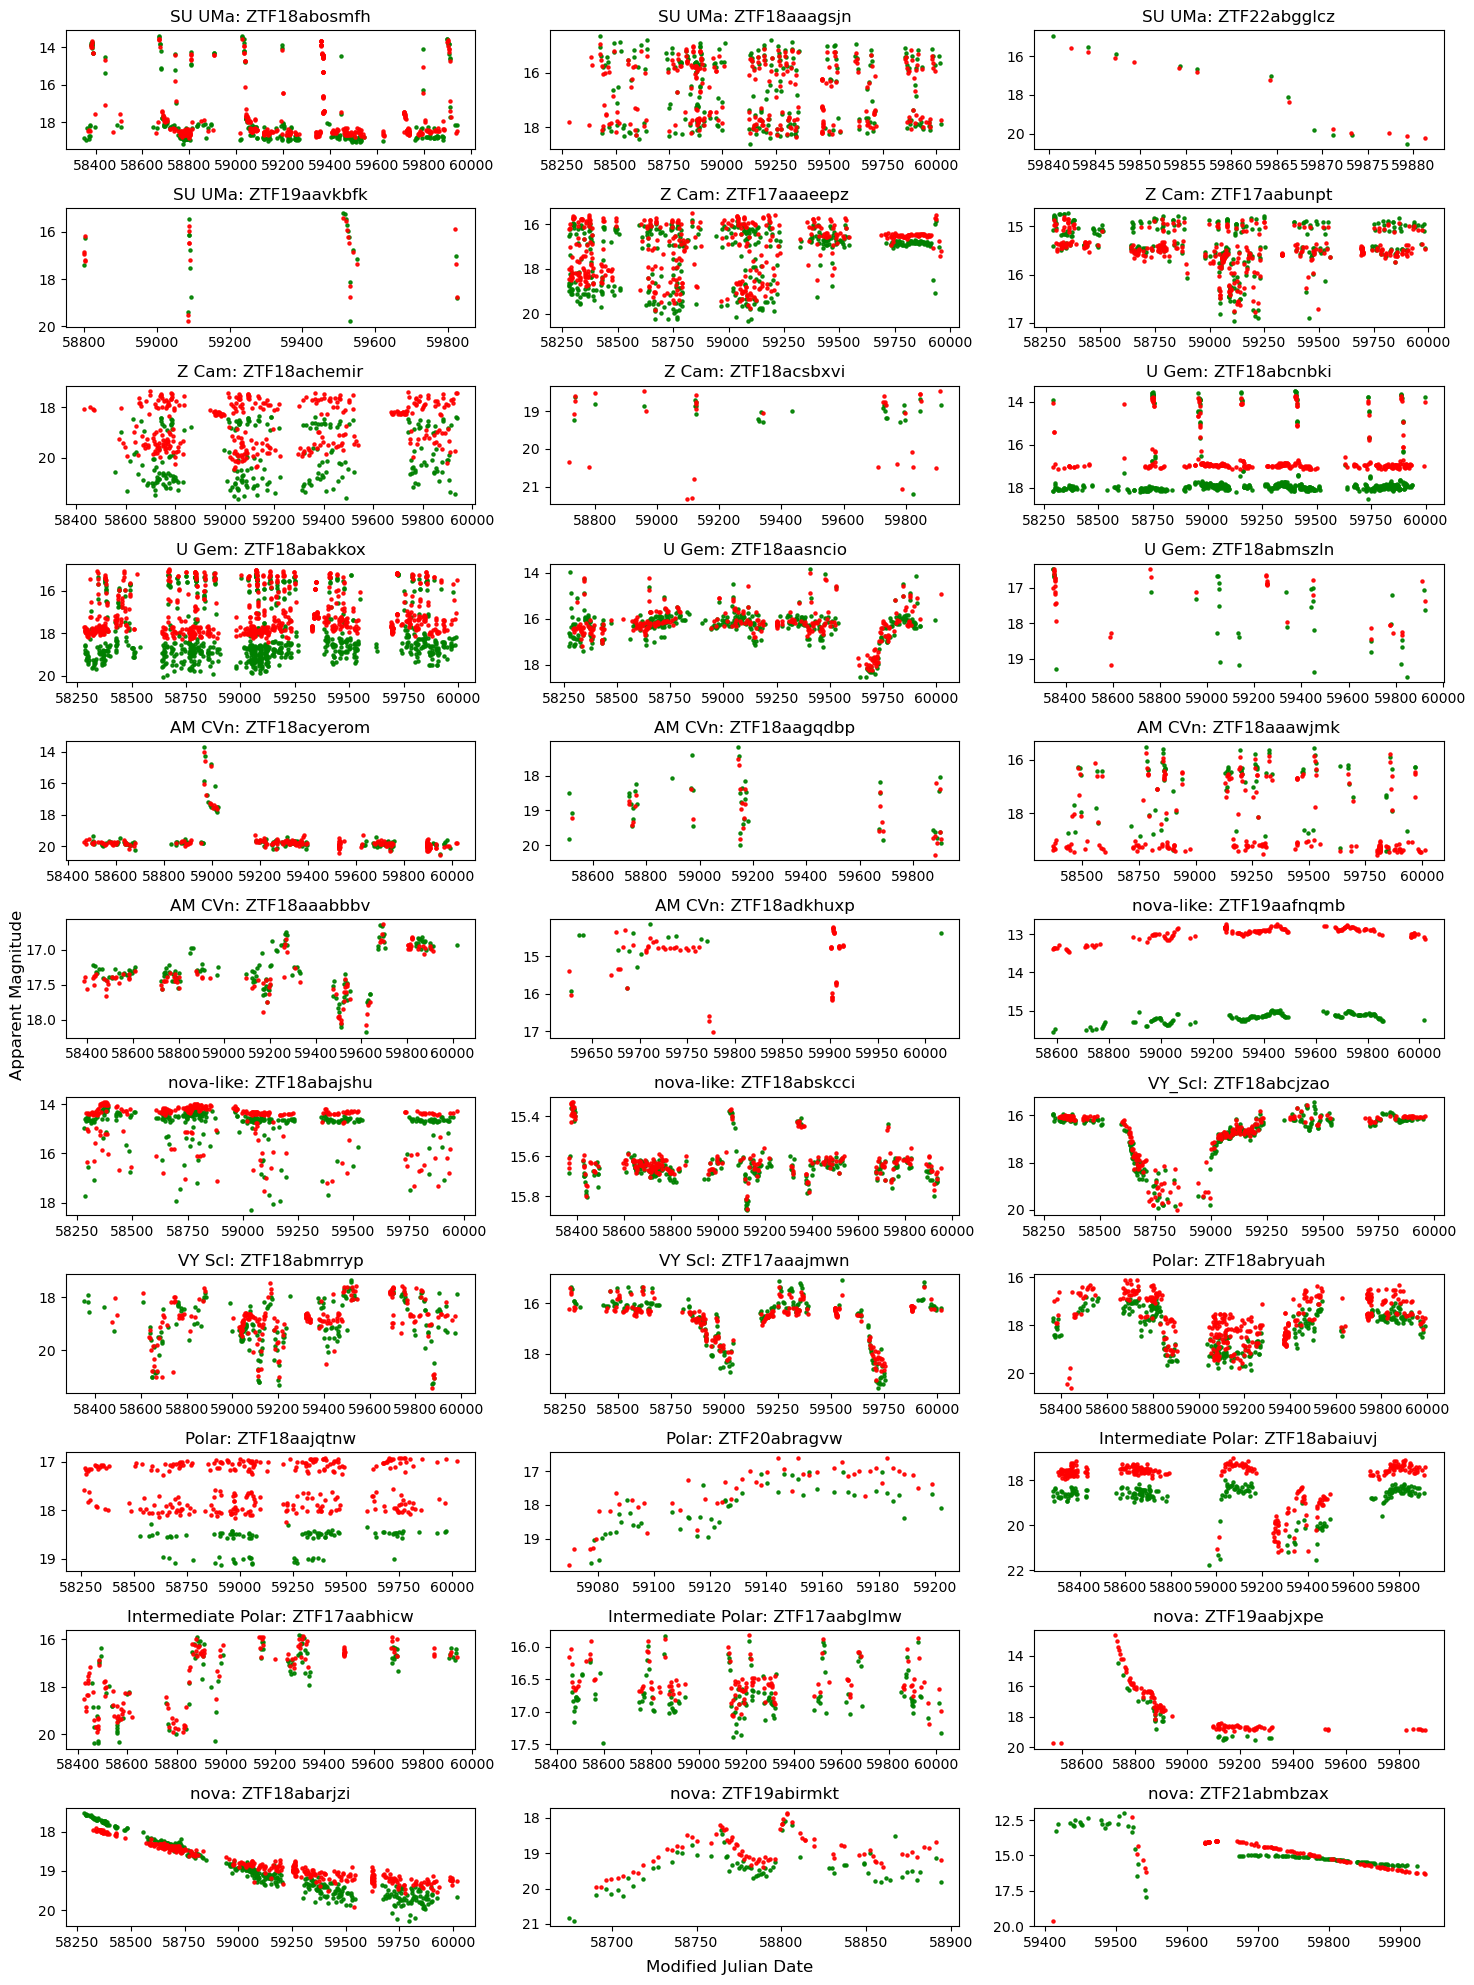

In [5]:
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter


fig, ax = plt.subplots(nrows=11,ncols=3,figsize=(15, 20), layout='tight')
fig.supxlabel('Modified Julian Date')
fig.supylabel('Apparent Magnitude')
s=5
fontsize = 10
alpha = 0.9

sources = np.array(['ZTF18abosmfh', 'ZTF18aaagsjn', 'ZTF22abgglcz',
                    'ZTF19aavkbfk', 'ZTF17aaaeepz', 'ZTF17aabunpt',
                    'ZTF18achemir', 'ZTF18acsbxvi', 'ZTF18abcnbki',
                    'ZTF18abakkox', 'ZTF18aasncio', 'ZTF18abmszln',
                    'ZTF18acyerom', 'ZTF18aagqdbp', 'ZTF18aaawjmk',
                    'ZTF18aaabbbv', 'ZTF18adkhuxp', 'ZTF19aafnqmb',
                    'ZTF18abajshu', 'ZTF18abskcci', 'ZTF18abcjzao',
                    'ZTF18abmrryp', 'ZTF17aaajmwn', 'ZTF18abryuah',
                    'ZTF18aajqtnw', 'ZTF20abragvw', 'ZTF18abaiuvj',
                    'ZTF17aabhicw', 'ZTF17aabglmw', 'ZTF19aabjxpe',
                    'ZTF18abarjzi', 'ZTF19abirmkt', 'ZTF21abmbzax'
                    ])

source_class = np.array(['SU UMa', 'SU UMa', 'SU UMa',
                         'SU UMa', 'Z Cam', 'Z Cam',
                         'Z Cam', 'Z Cam', 'U Gem',
                         'U Gem','U Gem','U Gem',
                         'AM CVn','AM CVn','AM CVn',
                         'AM CVn','AM CVn','nova-like',
                         'nova-like','nova-like','VY_Scl',
                         'VY Scl','VY Scl','Polar',
                         'Polar','Polar','Intermediate Polar',
                         'Intermediate Polar','Intermediate Polar','nova',
                         'nova','nova','nova'
                         ])

sources = sources.reshape(11,3)
source_class = source_class.reshape(11,3)


for row in range(11):
    for col in range(3):
        object = sources[row,col]
        try:
            lc_lasair = load_lasair_lc(object, path=f'../lightcurves_dataset/lasair_2023_03_25')
        except:
            # Create a folder within path for LCs if one does not exist
            if not os.path.exists(f'../lightcurves_dataset/lasair_non_dataset/cache'):
                os.makedirs(f'../lightcurves_dataset/lasair_non_dataset/cache')
            download_lasair_lc([object], folderpath=f'../lightcurves_dataset/lasair_non_dataset', cache=f'../lightcurves_dataset/lasair_non_dataset/cache')
            lc_lasair = load_lasair_lc(object, path=f'../lightcurves_dataset/lasair_non_dataset')
        
        lc_lasair_appmag = lasair_clean(lc_lasair, limit=25, magerrlim=1)
        
        lc_g = lc_lasair_appmag[lc_lasair_appmag['fid'] == 1]
        lc_r = lc_lasair_appmag[lc_lasair_appmag['fid'] == 2]
        ax[row,col].set_title(f'{source_class[row,col]}: {sources[row,col]}')
        ax[row,col].scatter(lc_g['jd']-2400000.5, lc_g['dc_mag'], c='green', s=s, label='g', alpha=alpha)
        ax[row,col].scatter(lc_r['jd']-2400000.5, lc_r['dc_mag'], c='red', s=s, label='r', alpha=alpha)
        ax[row,col].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax[row,col].invert_yaxis()


fig.savefig(f'../figures/class_lightcurves.pdf', bbox_inches='tight', format='pdf')

plt.show()


0 ZTF18aczycws
0 ZTF21acbqaqa
0 ZTF18acqllgh
0 ZTF23aaknjqb
0 ZTF18abceint
0 ZTF18aapaldh


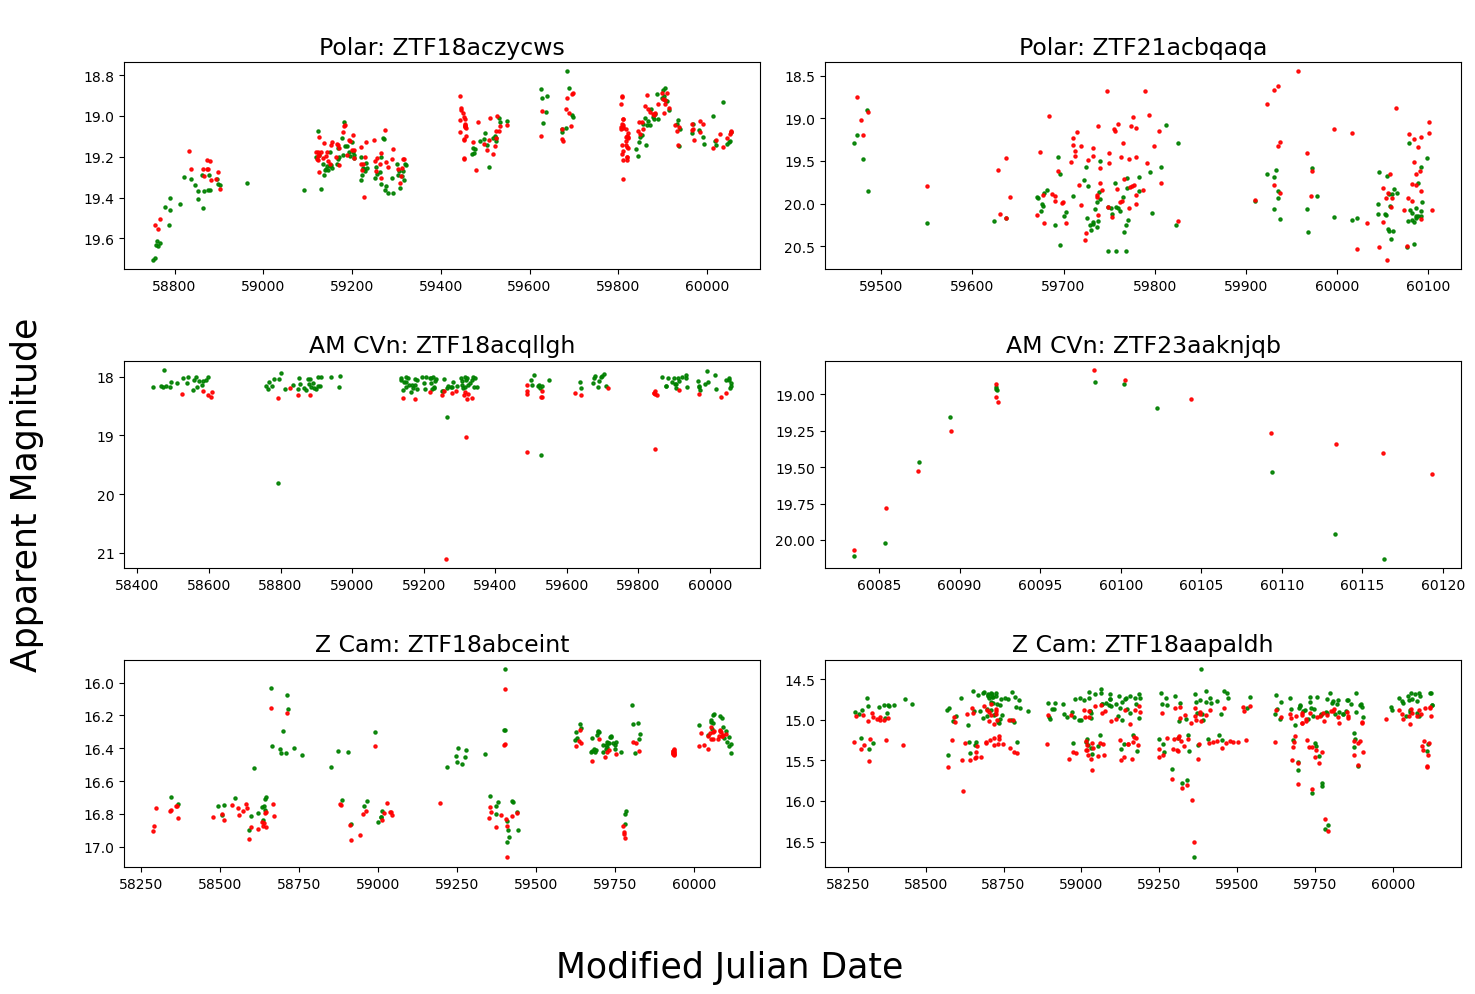

In [35]:
from matplotlib.ticker import FormatStrFormatter

r = 3
c = 2


fig2, ax2 = plt.subplots(nrows=r,ncols=c,figsize=(15, 10), layout='tight')
fig2.supxlabel('\nModified Julian Date', fontsize=25)
fig2.supylabel('Apparent Magnitude\n', fontsize=25)

s=5
fontsize = 17
alpha = 0.9


sources = np.array(['ZTF18aczycws',
                    'ZTF21acbqaqa',
                    'ZTF18acqllgh',
                    'ZTF23aaknjqb',
                    'ZTF18abceint',
                    'ZTF18aapaldh'
                    ])

source_class = np.array(['Polar',
                         'Polar',
                         'AM CVn',
                         'AM CVn',
                         'Z Cam',
                         'Z Cam'
                         ])

sources = sources.reshape(r,c)
source_class = source_class.reshape(r,c)


for row in range(r):
    for col in range(c):
        object = sources[row,col]
        try:
            lc_lasair = load_lasair_lc(object, path=f'../lightcurves_dataset/lasair_2023_03_25')
        except:
            # Create a folder within path for LCs if one does not exist
            if not os.path.exists(f'../lightcurves_dataset/lasair_non_dataset/cache'):
                os.makedirs(f'../lightcurves_dataset/lasair_non_dataset/cache')
            download_lasair_lc([object], folderpath=f'../lightcurves_dataset/lasair_non_dataset', cache=f'../lightcurves_dataset/lasair_non_dataset/cache')
            lc_lasair = load_lasair_lc(object, path=f'../lightcurves_dataset/lasair_non_dataset')
        
        lc_lasair_appmag = lasair_clean(lc_lasair, limit=25, magerrlim=1)
        
        lc_g = lc_lasair_appmag[lc_lasair_appmag['fid'] == 1]
        lc_r = lc_lasair_appmag[lc_lasair_appmag['fid'] == 2]
        ax2[row,col].set_title(f'\n{source_class[row,col]}: {sources[row,col]}', fontsize=fontsize)
        ax2[row,col].scatter(lc_g['jd']-2400000.5, lc_g['dc_mag'], c='green', s=s, label='g', alpha=alpha)
        ax2[row,col].scatter(lc_r['jd']-2400000.5, lc_r['dc_mag'], c='red', s=s, label='r', alpha=alpha)
        ax2[row,col].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax2[row,col].invert_yaxis()

fig2.savefig(f'../figures/class_lightcurves2.pdf', bbox_inches='tight', format='pdf')





ZTF18aczycws
0 ZTF18aczycws
ZTF21acbqaqa
0 ZTF21acbqaqa
ZTF18acqllgh
0 ZTF18acqllgh
ZTF23aaknjqb
0 ZTF23aaknjqb
ZTF18abceint
0 ZTF18abceint
ZTF18aapaldh
0 ZTF18aapaldh
downloading light curve ZTF18aapaldh


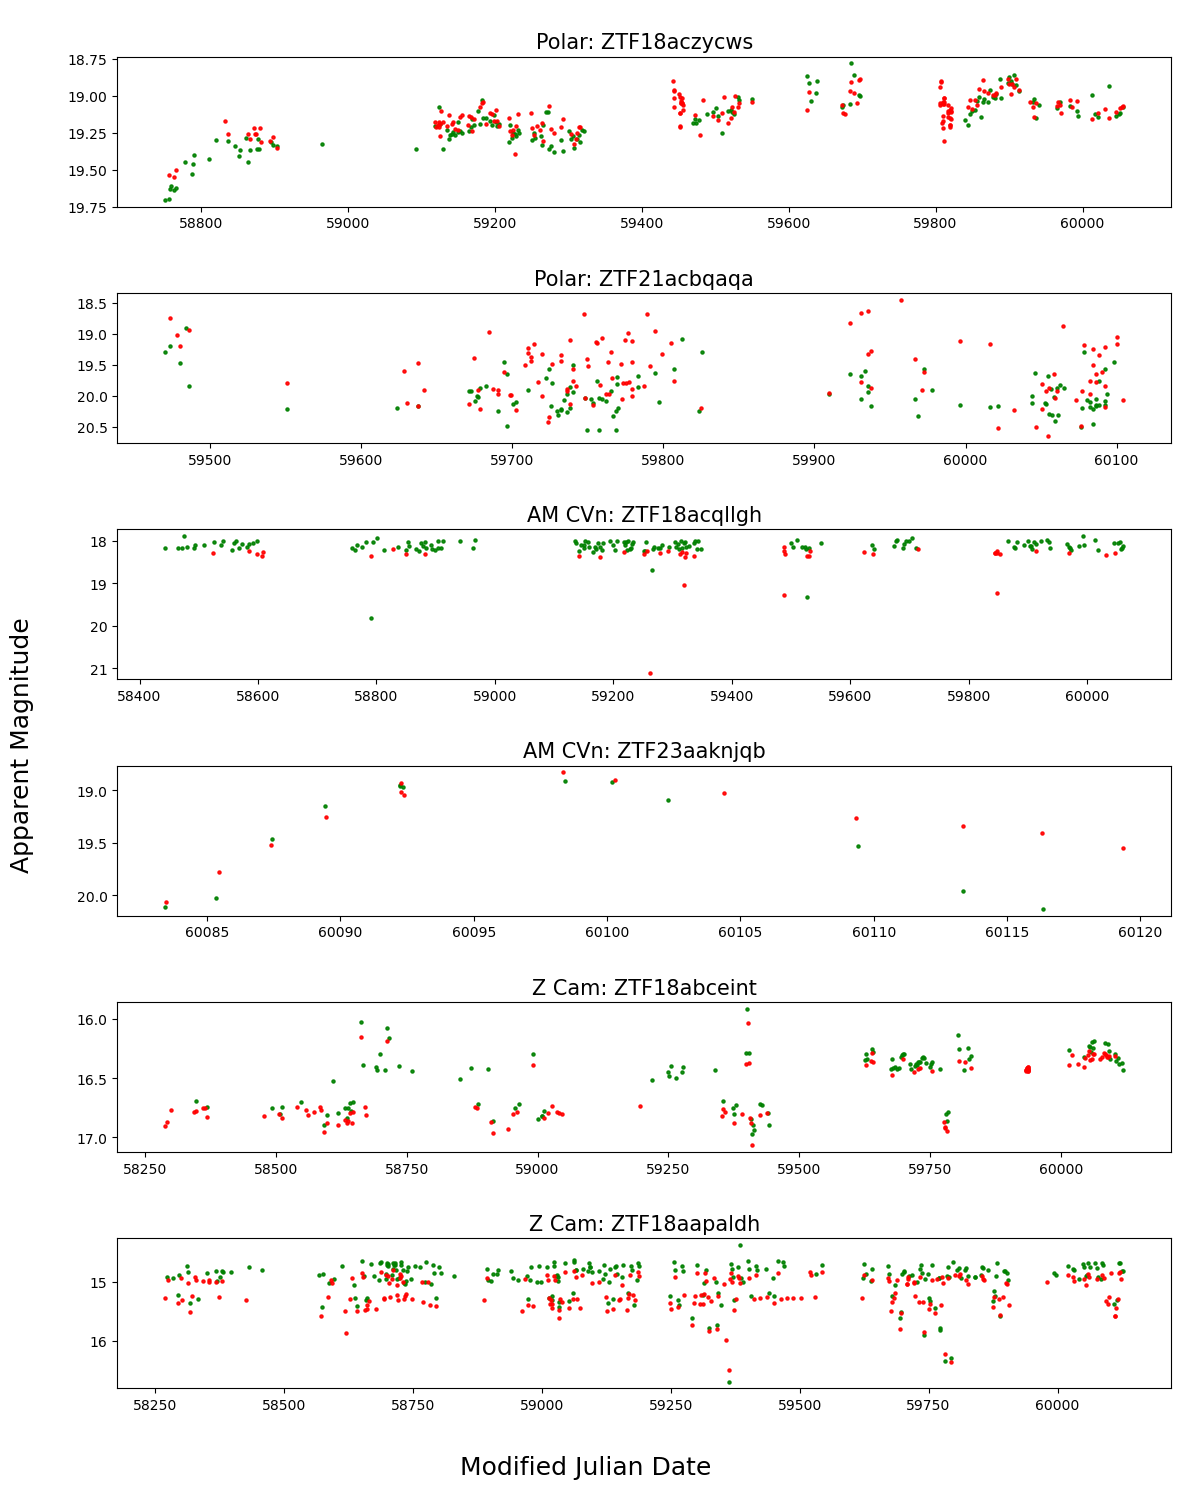

In [32]:
from matplotlib.ticker import FormatStrFormatter

r = 6
c = 1


fig2, ax2 = plt.subplots(nrows=r,ncols=c,figsize=(12, 15), layout='tight')
fig2.supxlabel('\nModified Julian Date', fontsize=18)
fig2.supylabel('Apparent Magnitude\n', fontsize=18)

s=5
fontsize = 15
alpha = 0.9


sources = np.array(['ZTF18aczycws',
                    'ZTF21acbqaqa',
                    'ZTF18acqllgh',
                    'ZTF23aaknjqb',
                    'ZTF18abceint',
                    'ZTF18aapaldh'
                    ])

                    

source_class = np.array(['Polar',
                         'Polar',
                         'AM CVn',
                         'AM CVn',
                         'Z Cam',
                         'Z Cam'
                         ])
                         



# sources = np.array(['ZTF18abosmfh', 'ZTF17aaaeepz', 
#                     'ZTF18abcnbki', 'ZTF18acyerom', 
#                     'ZTF18aaabbbv', 'ZTF18abajshu', 
#                     'ZTF17aaajmwn', 'ZTF18abryuah', 
#                     'ZTF17aabglmw', 'ZTF21abmbzax'
#                     ])

# source_class = np.array(['SU UMa', 'Z Cam', 
#                          'U Gem', 'AM CVn',
#                          'AM CVn','nova-like',
#                          'VY Scl', 'Polar', 
#                          'Intermediate Polar', 'nova'
#                          ])

sources = sources.reshape(r,c)
source_class = source_class.reshape(r,c)


for row in range(r):
    for col in range(c):
        object = sources[row].item()
        print(object)
        try:
            lc_lasair = load_lasair_lc(object, path=f'../lightcurves_dataset/lasair_2023_03_25')
        except:
            # Create a folder within path for LCs if one does not exist
            if not os.path.exists(f'../lightcurves_dataset/lasair_non_dataset/cache'):
                os.makedirs(f'../lightcurves_dataset/lasair_non_dataset/cache')
            download_lasair_lc([object], folderpath=f'../lightcurves_dataset/lasair_non_dataset', cache=f'../lightcurves_dataset/lasair_non_dataset/cache')
            lc_lasair = load_lasair_lc(object, path=f'../lightcurves_dataset/lasair_non_dataset')
        
        lc_lasair_appmag = lasair_clean(lc_lasair, limit=25, magerrlim=1)
        
        lc_g = lc_lasair_appmag[lc_lasair_appmag['fid'] == 1]
        lc_r = lc_lasair_appmag[lc_lasair_appmag['fid'] == 2]
        ax2[row].set_title(f'\n{source_class[row].item()}: {sources[row].item()}', fontsize=fontsize)
        ax2[row].scatter(lc_g['jd']-2400000.5, lc_g['dc_mag'], c='green', s=s, label='g', alpha=alpha)
        ax2[row].scatter(lc_r['jd']-2400000.5, lc_r['dc_mag'], c='red', s=s, label='r', alpha=alpha)
        ax2[row].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax2[row].invert_yaxis()

fig2.savefig(f'../figures/class_lightcurves2.pdf', bbox_inches='tight', format='pdf')